#PyTorch Workflow

Exploring PyTorch end-to-end workflow


1. Prepare data and load
2. Build model
3. Fitting the model to data (training)
4. Making predictions and evaluating the model (inference)
5. Saving and loading a model
6. Putting it all together

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.5.1+cu121'

##1. Data (preparing and loading)

Data can be almost anything

* Excel Spreadsheets
* Images
* Videos
* Audio
* DNA
* Text

Steps in machine learning:

  1) Get data into numerical representation

  2) Build a model to create patterns in that numerical represenation

We'll using a linear regression formula to make a straight line with *known* **parameters**

In [2]:
#formula of linear regression
#Y = weight*x + bias

#create
weight = 0.7
bias = 0.3

#create
start = 0
end = 1
step = 0.02
x = torch.arange(start, end, step).unsqueeze(dim=1) #unsqueeze adds an extra dimension
y = weight*x + bias

x[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [3]:
len(x), len(y)

(50, 50)

###Splitting into training and testing datasets

Creating training and testing set

In [4]:
#Creating a test/train split
train_split = int(0.8*len(x))
x_train, y_train = x[:train_split], y[:train_split]
x_test, y_test = x[train_split:], y[train_split:]

len(x_train), len(y_train), len(x_test), len(y_test)

(40, 40, 10, 10)

Visualizing the data

In [5]:
def plot_predictions(train_data = x_train,
                     train_labels = y_train,
                     test_data = x_test,
                     test_labels = y_test,
                     predictions=None):

  plt.figure(figsize=(7,4))
  #plot the training data
  plt.scatter(train_data, train_labels, c="b", label="Training Data")

  #plot the testing data
  plt.scatter(test_data, test_labels, c="g", label="Testing Data")

  #Are there predictions

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", label="Predictions")

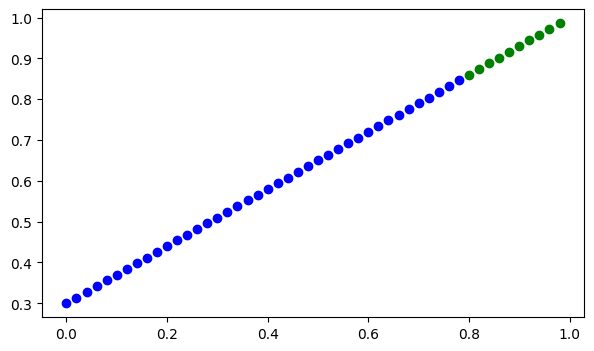

In [6]:
plot_predictions()

 ## 2. Build model
 First PyTorch model

 What the model does:


*   Start with random values (weights and bias)
*   Look at training data and adjust the random values to get closer to the ideal values (weights and bias values we used to create the data)

How does it do that?

*  Gradient Descent
*  Backpropogation





In [7]:
import torch
from torch import nn

class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weight = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.weight*x + self.bias


###Pytorch model building essentials

* torch.nn - all the buildings for creating neura networks
* torch.nn.Parameter - what parameters the model should try and learn for building neural network
* torch.nn.Module - base class for all neural network modules. If you subclass it then overwrite the forward() method
* torch.optim - where the optimizers in PyTorch are, they help in gradient descent
* def forward() - all nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation.

###Checking the contents of our PyTorch model

We can the check our model's parameters/what's inside the model using `.parameters()`

In [8]:
# Create a random seed
torch.manual_seed(42)

#create an instance of the model

model_0 = LinearRegressionModel()

list(model_0.parameters())


[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
#List named parameters
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

To check out mode's predictive power how well it predicts y_test based on x_test.


In [10]:
x_test, y_test

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

In [11]:
#making prediction

with torch.inference_mode():
  y_preds = model_0(x_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

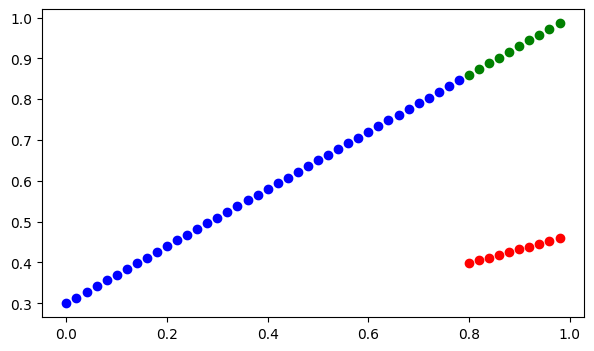

In [12]:
 plot_predictions(predictions = y_preds)

 ## 3. Train model

 Movie from random values to known (required) values

 Measuring how poor or how wrong the mode's prediction is called the "Loss Function"

 * **Lost function** may also be called "cost function" or "criterion"

* **Optimizers** takes in to account the loss of a model and adjusts the mode's parameters (weights and biases) to improve the loss function

In PyTorch we create training and testing loop

In [13]:
#setup a loss function
loss_fn = nn.L1Loss()

#setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.01) #lr is hyperparameter, which means the user sets it themselves



### Building a training loop in PyTorch

Steps for a training loop:
0.   Loop through the data
1.   Forward pass (data moving through forward function)
2.   Calculate the loss (compare the forward pass prediction to ground truth labels
3.   Optimizer zero grad
4.   Loss Backward - move backward through the network to calculate the gradients of the each parameter (**backpropogation**)
5.   Optimizer step - adjusts the model's parameters to try and improve the loss (**gradient descent**)



In [14]:
torch.manual_seed(42)
#An epoch is the number of times the loop happens
epochs = 200

epoch_count = []
loss_values = []
test_loss_values = []

###TRAINING LOOP
for epoch in range(epochs):
  #Put the model in train mode
  model_0.train()

  #1. Forward pass(using the forward function), find the prediction value
  y_pred = model_0(x_train)

  #2. find the loss
  loss = loss_fn(y_pred, y_train)
  #print(f"Loss: {loss}")

  #3. Optimizer zero the grad
  optimizer.zero_grad()

  #4. Perform backpropogation on the loss wrt to the parameters of the model (calcualte the gradient at each parameter)
  loss.backward()

  #Step the optimizer(perform gradient descent)
  optimizer.step()

  ###TESTING loop
  model_0.eval() #turns of setting in the model that are not needed for evaluation
  with torch.inference_mode():
    #1. Do the forward pass
    test_pred = model_0(x_test)
    #2. get loss
    test_loss = loss_fn(test_pred, y_test)

    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
  if epoch%10==0:
    print(f"Epoch {epoch}: | Loss: {loss} | Test loss: {test_loss}")

    print(model_0.state_dict())

Epoch 0: | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weight', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch 10: | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weight', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch 20: | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weight', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch 30: | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weight', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch 40: | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weight', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch 50: | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weight', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch 60: | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weight', tensor([0.5116])), ('bias', tensor([0.3788]))])
E

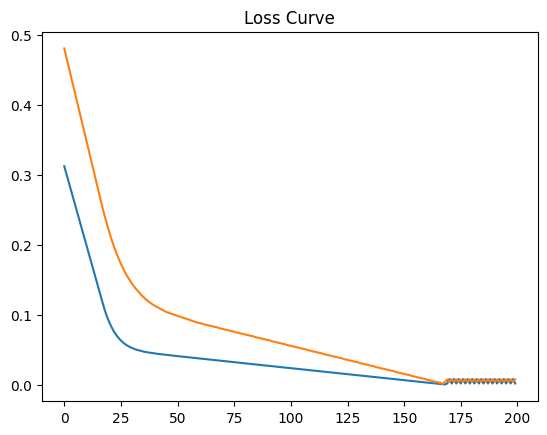

In [15]:
import numpy as np
#plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).cpu().numpy()), label="Train Loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")
plt.title("Loss Curve")
plt.show()

In [16]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [17]:
with torch.inference_mode():
  y_preds_new = model_0(x_test)


In [18]:
weight, bias

(0.7, 0.3)

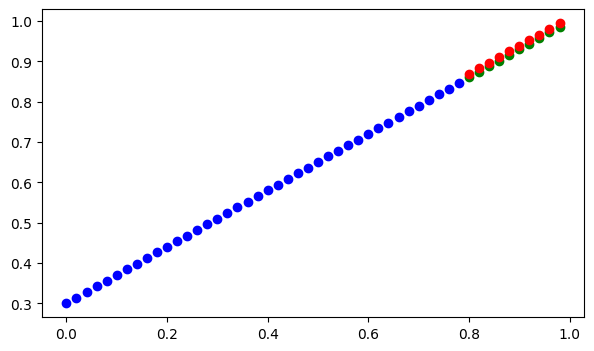

In [19]:
plot_predictions(predictions=y_preds_new)

##Saving a model in PyTorch

3 main methods to save and load models


1.   `torch.save()` : stores PyTorch object in python's pickle format
2.   `torch.load()` : allows your to load a saved PyTorch object
3.   `torch.nn.Module.load_state_dict()` : allows to load an object's saved state dictionary



In [20]:
#Saving a PyTorch model
from pathlib import Path

# 1. Create a models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)


# 2. Creat a model save path
MODEL_NAME = "01_pytorch_workflow.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(model_0.state_dict, MODEL_SAVE_PATH)


Saving model to models/01_pytorch_workflow.pth


#Loading a PyTorch model
We have to create a new instance of the model and load the state dict in that

In [21]:
#Instantiate a new instance of the model
loaded_model_0 = LinearRegressionModel()

#Load the saved state_dict of the model_0
#loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

In [22]:
loaded_model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

##Putting it all together

Do all the steps again

In [23]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.5.1+cu121'

 Creating device agnostic code


In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cpu


Making data

In [25]:
weight = 0.7
bias = 0.3

x = torch.arange(0,1,0.02).unsqueeze(dim=1)
y = x*weight + bias


In [26]:
split = int(0.8*len(x))

x_train, y_train = x[:split], y[:split]
x_test, y_test = x[split:], y[split:]

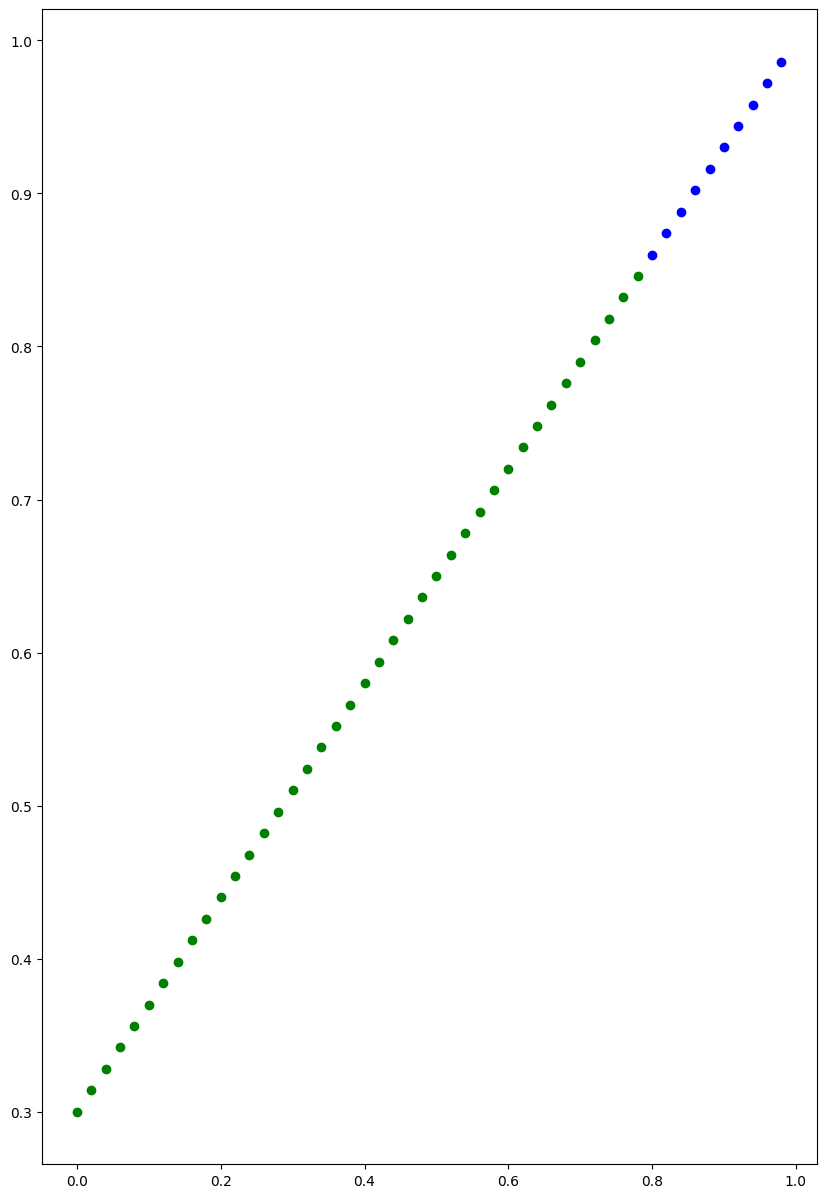

In [27]:
def plot_prediction(test_data= x_test,
                    test_labels=y_test,
                    train_data=x_train,
                    train_labels = y_train,
                    prediction=None):

  plt.figure(figsize=(10,15))

  plt.scatter(train_data, train_labels, c="g", label="Training data")
  plt.scatter(test_data, test_labels, c="b", label="Testing data")

  if prediction is not None:
    plt.scatter(test_data, test_labels, c="hotpink", label="Testing data")

plot_prediction()

Training function

In [28]:
import torch
from torch import nn

class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    ## use nn.linear to create model parameters aka linear layer, probing layerm fully connected layer, dense layer
    self.linear_layer = nn.Linear(in_features=1, out_features=1)



  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

torch.manual_seed(42)
model_1 = LinearRegressionModel()
model_1, model_1.state_dict( )

(LinearRegressionModel(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [29]:
loss_fn = nn.L1Loss() #Same as MAE
optimizer = torch.optim.SGD(params = model_1.parameters(), lr=0.01)

Training Loop

In [30]:
torch.manual_seed(42)

epochs = 200
epoch_value = []
train_loss = []
test_loss = []

for epoch in range(epochs):
  #put in train mode
  model_1.train()

  #run forward function
  y_pred = model_1(x_train)

  #find loss function
  loss = loss_fn(y_pred, y_train)

  #zero grad-ing the optimizer
  optimizer.zero_grad()

  #backpropogation
  loss.backward()

  #optimizer step
  optimizer.step()

  ###TESTING LOOP
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(x_test)
    test_loss_value = loss_fn(test_pred, y_test)

    epoch_value.append(epoch)
    train_loss.append(loss)
    test_loss.append(test_loss_value)

  if epoch%10==0:
    print(f"Epoch: {epoch} | Train Loss={loss} | Test Loss={test_loss_value}")
    print(model_0.state_dict())



Epoch: 0 | Train Loss=0.5551779866218567 | Test Loss=0.5739762187004089
OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])
Epoch: 10 | Train Loss=0.4399680495262146 | Test Loss=0.4392663538455963
OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])
Epoch: 20 | Train Loss=0.3247582018375397 | Test Loss=0.30455657839775085
OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])
Epoch: 30 | Train Loss=0.20954827964305878 | Test Loss=0.16984674334526062
OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])
Epoch: 40 | Train Loss=0.09433844685554504 | Test Loss=0.03513689711689949
OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])
Epoch: 50 | Train Loss=0.023886386305093765 | Test Loss=0.04784906655550003
OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])
Epoch: 60 | Train Loss=0.0199567973613739 | Test Loss=0.04580312222242355
OrderedDict([('weight', tensor([0.6990])), ('bias

In [31]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])

In [32]:
with torch.inference_mode():
  y_preds = model_1(x_test)

y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]])

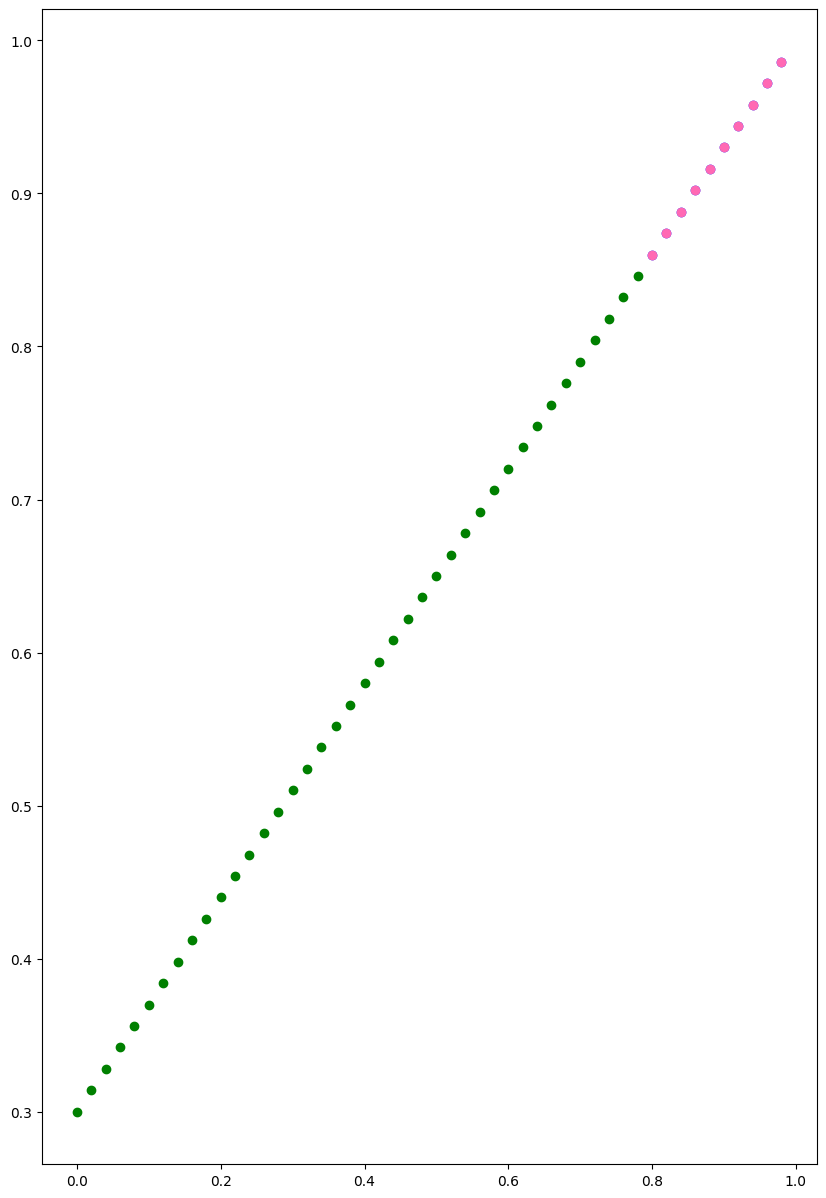

In [33]:
 #See the outputs visually

 plot_prediction(prediction=y_preds)

Saving and load the model

In [34]:
from pathlib import Path

#Create a models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#Create a model save path
MODEL_NAME = "01_pytorch_workflow.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#Save the model state dict
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f = MODEL_SAVE_PATH)

Saving model to models/01_pytorch_workflow.pth


In [35]:
#Load a pytorch model
loaded_model_1 = LinearRegressionModel()
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

loaded_model_1

<ipython-input-35-36281ca0508f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


LinearRegressionModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)